### Neural Networks

In [6]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow import set_random_seed

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint

import utils
from constants import DATA_DIR

In [7]:
np.random.seed(23)
set_random_seed(23)

warnings.filterwarnings("ignore")

In [8]:
def root_mean_squared_error(y_true, y_pred):
    # Custom loss function for keras
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 


def get_modelcheckpoint_path(model_num):
    #Create a file path for a model and save models in hdf5 files with datetime, validation losses and epochs
    parent = DATA_DIR+"/Models/NN/Model_{}/".format(model_num)
    child = pd.Timestamp.now().strftime('%Y%m%d-%Hh%Mm') + "-model-epoch_{epoch:02d}-rmse_{val_loss:.5f}.hdf5"
    return parent + child 


def get_weights_path_and_epoch(model_num):
    filepaths = glob.glob(DATA_DIR+"/Models/NN/Model_{}/*.hdf5".format(str(model_num)))
    losses = [float(filepath[-12:-5]) for filepath in filepaths]
    epochs = losses.index(min(losses))
    print('Model {} | Lowest Valid Error: {} at Epoch {}'.format(model_num, min(losses), epochs))
    return (filepaths[losses.index(min(losses))], epochs)


def plot_learning_process(hist_list):
    for i, hist in enumerate(hist_list):
        plt.subplot(1,1,1)  
        plt.plot(hist.history['loss'])  
        plt.plot(hist.history['val_loss'])  
        plt.title('Model Loss')  
        plt.ylabel('Loss')  
        plt.xlabel('Epoch')  
        plt.legend(['Train', 'Validation'], loc='upper right')  
        plt.show()
    return None


def run_models():
    for i in range(1, 4):
        print(create_model(i)().summary())
        model = KerasRegressor(build_fn=create_model(i),
                               epochs=100,
                               batch_size=32,
                               validation_split=0.2,
                               shuffle=True,
                               verbose=1)

        filepath = get_modelcheckpoint_path(i)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=0, mode='min')
        callbacks_list = [checkpoint]
        
        if i == 1:
            h1 = model.fit(X, y, callbacks=callbacks_list)
        elif i == 2:
            h2 = model.fit(X, y, callbacks=callbacks_list)
        elif i == 3:
            h3 = model.fit(X, y, callbacks=callbacks_list)
            
    return [h1, h2, h3]


def create_model(model_num):
    def model_1():
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
        model.compile(loss=root_mean_squared_error, optimizer='adam')
        return model

    def model_2():
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=root_mean_squared_error, optimizer='adam')
        return model

    def model_3():
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=root_mean_squared_error, optimizer='adam')
        return model
    
    if model_num == 1:
        return model_1
    elif model_num == 2:
        return model_2
    elif model_num == 3:
        return model_3
    else:
        return "invalid model_num"

In [9]:
X, y = utils.load_full_dataset('quad')

In [11]:
# Takes about ~ 30 mins for training 100 epochs for all models
hist_list = run_models()

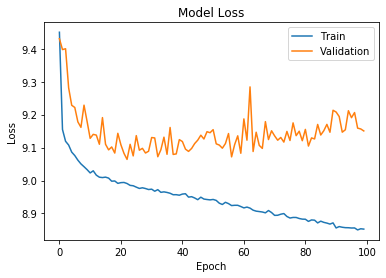

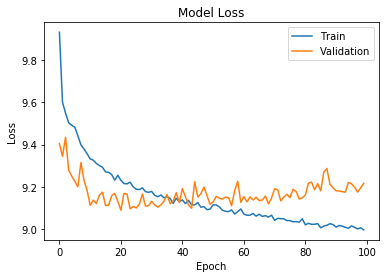

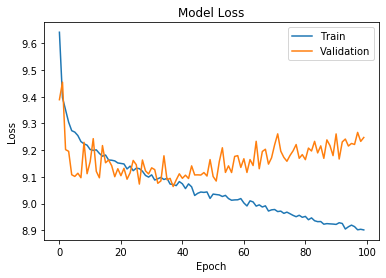

In [30]:
# The models seem to overfit at an early stage for all models
plot_learning_process(hist_list)

In [28]:
for i in range(1, 4):
    weights_path, epochs = get_weights_path_and_epoch(i)
    model = KerasRegressor(build_fn=create_model(i),
                           epochs=epochs,
                           batch_size=32,
                           validation_split=0.2,
                           shuffle=True,
                           verbose=0)
    
    errors = utils.cross_val(model, X, y, n_folds=5)
    utils.summarize_errors(errors, verbose=1)

Model 1 | Lowest Valid Error: 9.06407 at Epoch 4


,,,,,
MAE,,,,,
train,7.104619,7.093637,7.081982,6.987312,7.041672
valid,7.157601,7.155964,7.048330,6.970658,7.026474


,,,,,
RMSE,,,,,
train,9.200789,9.180906,9.312114,9.164618,9.156726
valid,9.259978,9.276065,9.303126,9.119281,9.132811



   <--- Validation Errors --->
MAE  | Mean: 7.07181, SD: 0.07387
RMSE | Mean: 9.21825, SD: 0.07666

Model 2 | Lowest Valid Error: 9.08894 at Epoch 6


,,,,,
MAE,,,,,
train,6.974793,7.075141,7.240280,7.003266,7.018079
valid,7.048455,7.134515,7.225957,6.992152,6.990194


,,,,,
RMSE,,,,,
train,9.154584,9.191060,9.324433,9.267034,9.259054
valid,9.237600,9.287955,9.316102,9.222004,9.234972



   <--- Validation Errors --->
MAE  | Mean: 7.07825, SD: 0.0906
RMSE | Mean: 9.25973, SD: 0.03606

Model 3 | Lowest Valid Error: 9.06403 at Epoch 7


,,,,,
MAE,,,,,
train,6.937657,6.953649,7.044424,7.104365,7.236153
valid,6.999789,7.014042,7.038410,7.108518,7.247965


,,,,,
RMSE,,,,,
train,9.115793,9.087052,9.153248,9.234147,9.343228
valid,9.192974,9.185803,9.168075,9.221036,9.335152



   <--- Validation Errors --->
MAE  | Mean: 7.08174, SD: 0.09113
RMSE | Mean: 9.22061, SD: 0.05976



### Neural Networks (Model 1) trained to Epoch 28
 - MAE  | Mean: 7.07181, SD: 0.07387
 - RMSE | Mean: 9.21825, SD: 0.07666